<a href="https://colab.research.google.com/github/aww-semenyuk/toxic-comments-classification/blob/aww-semenyuk/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data

In [ ]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn gensim optuna ipywidgets catboost xgboost lightgbm

In [ ]:
toxicity_cols = [
    'toxicity',
    'obscene',
    'identity_attack',
    'insult',
    'threat',
    'sexual_explicit']

cols_to_load = toxicity_cols + ['created_date', 'comment_text', 'comment_text_tokenized_tab', 'toxicity_annotator_count']

In [ ]:
import pandas as pd
df = pd.read_csv('./data_tokenized.csv', usecols=cols_to_load, parse_dates=['created_date'], date_format='ISO8601')
df.head()

,toxicity,comment_text,obscene,identity_attack,insult,threat,created_date,sexual_explicit,toxicity_annotator_count,comment_text_tokenized_tab
0,0.000000,"This is so cool. It's like, 'would you want yo...",0.0,0.000000,0.00000,0.0,2015-09-29 10:50:41.987077+00:00,0.0,4,cool\tlike\twould\twant\tmother\tread\treally\...
1,0.000000,Thank you!! This would make my life a lot less...,0.0,0.000000,0.00000,0.0,2015-09-29 10:50:42.870083+00:00,0.0,4,thank\twould\tmake\tlife\tlot\tless\tanxiety\t...
2,0.000000,This is such an urgent design problem; kudos t...,0.0,0.000000,0.00000,0.0,2015-09-29 10:50:45.222647+00:00,0.0,4,urgent\tdesign\tproblem\tkudo\ttake\timpressive
3,0.000000,Is this something I'll be able to install on m...,0.0,0.000000,0.00000,0.0,2015-09-29 10:50:47.601894+00:00,0.0,4,something\table\tinstall\tsite\trelease
4,0.893617,haha you guys are a bunch of losers.,0.0,0.021277,0.87234,0.0,2015-09-29 10:50:48.488476+00:00,0.0,47,haha\tguy\tbunch\tloser


In [ ]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv('/content/drive/MyDrive/toxic_comments_tmp/data_tokenized.csv', usecols=cols_to_load, parse_dates=['created_date'], date_format='ISO8601')

# drive.flush_and_unmount()

# df.head()

## Split data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import os
import logging

In [ ]:
df = df.dropna(subset='comment_text').sort_values(by='toxicity_annotator_count', ascending=False).drop_duplicates(subset='comment_text', keep='first').reset_index(drop=True)
df = df.drop(['comment_text', 'toxicity_annotator_count'], axis=1)

df['comment_text_tokenized_tab'] = df['comment_text_tokenized_tab'].fillna('').astype('str')

df = df[df['created_date'] >= '2016-06-01'].reset_index(drop=True)

for col in toxicity_cols:
    df[col] = np.where(df[col] >= 0.4, 1, 0).astype('uint8')

df.head()

,toxicity,obscene,identity_attack,insult,threat,created_date,sexual_explicit,comment_text_tokenized_tab
0,1,1,0,0,0,2017-04-10 23:30:10.076014+00:00,1,stick\tdick\tanyone\t's\tbutt\tlaw
1,1,1,0,1,0,2017-06-08 18:24:06.236150+00:00,1,bet\tfat\tbitter\tlittle\tnerd\tass\twait\tday...
2,1,0,0,1,1,2017-05-23 18:10:27.505027+00:00,0,hope\tdie\ttoday\tworld\tmuch\twell\twithout\t...
3,1,0,0,0,1,2017-06-26 21:37:55.561744+00:00,0,let\tdie\tmaybe\tbuild\tconcentration\tcamp\tg...
4,1,0,0,1,1,2017-07-13 21:15:03.037890+00:00,0,shoot\tpermanent\tsolution\tcreature\twaste\ts...


In [ ]:
test_split_date = df['created_date'].quantile(0.8)
test_split_mask = (df['created_date'] >= test_split_date)

validation_split_date = df[~test_split_mask]['created_date'].quantile(0.8)
validation_split_mask = (df[~test_split_mask]['created_date'] >= validation_split_date)

text_col = 'comment_text_tokenized_tab'

X, y = df[text_col], df[toxicity_cols]

X_train, y_train, X_test, y_test = (df[text_col][~test_split_mask],
                                    df[toxicity_cols][~test_split_mask],
                                    df[text_col][test_split_mask],
                                    df[toxicity_cols][test_split_mask])

X_train, y_train, X_val, y_val = (X_train[~validation_split_mask],
                                  y_train[~validation_split_mask],
                                  X_train[validation_split_mask],
                                  y_train[validation_split_mask])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score, classification_report, average_precision_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader

from functools import partial
from tqdm import tqdm
tqdm.pandas()

## Word2Vec pretrained (google-news-300)

In [ ]:
# list(gensim.downloader.info()['models'].keys())

In [ ]:
# gn300_path = gensim.downloader.load('word2vec-google-news-300', return_path=True)
gn300_path = './word2vec-google-news-300.gz'
gn300_path

'./word2vec-google-news-300.gz'

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format(gn300_path, binary=True)

In [ ]:
len(word_vectors), word_vectors.vector_size

(3000000, 300)

### Averaging token embeddings

In [ ]:
def tokenized_text_to_vec(text, emb_dict, emb_dim, token_sep='\t'):
    words = text.split(token_sep)
    vecs = [emb_dict[word] for word in words if word in emb_dict]
    return np.mean(vecs, axis=0) if vecs else np.zeros(emb_dim)

In [ ]:
X_train_wv = np.vstack(X_train.progress_apply(tokenized_text_to_vec, emb_dict=word_vectors, emb_dim=word_vectors.vector_size).values)
X_val_wv = np.vstack(X_val.progress_apply(tokenized_text_to_vec, emb_dict=word_vectors, emb_dim=word_vectors.vector_size).values)

100%|██████████| 273230/273230 [00:18<00:00, 14799.37it/s]


In [ ]:
%%time
lr = LogisticRegression().fit(X_train_wv, y_train['toxicity'])

CPU times: user 4min 11s, sys: 15min 38s, total: 19min 50s
Wall time: 1min 40s


In [ ]:
f1_score(y_val['toxicity'], lr.predict(X_val_wv))

0.28021477539671125

In [ ]:
roc_auc_score(y_val['toxicity'], lr.predict_proba(X_val_wv)[:, 1])

0.8456670429986215

In [ ]:
del X_train_wv
del X_val_wv

### Tf-Idf'ing token embeddings

In [ ]:
def get_corpus_embs_tfidf(corpus, emb_dict, emb_dim, tfidf_vectorizer):
    tfidf = tfidf_vectorizer.transform(corpus)
    features = tfidf_vectorizer.get_feature_names_out()
    features_embs = np.array([emb_dict[word] if word in emb_dict else np.zeros(emb_dim) for word in features])

    weighted_embs = tfidf @ features_embs

    norms = np.linalg.norm(weighted_embs, axis=1, keepdims=True)
    weighted_embs = np.divide(weighted_embs, norms, where=norms>0)

    return weighted_embs

In [ ]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1),
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
vec.fit(X_train)

CPU times: user 14.3 s, sys: 162 ms, total: 14.4 s
Wall time: 14.5 s


TfidfVectorizer(lowercase=False, token_pattern=None,
                tokenizer=<function <lambda> at 0x7fce1f601fc0>)

In [ ]:
%%time
X_train_wv_tfidf = get_corpus_embs_tfidf(X_train, word_vectors, word_vectors.vector_size, vec)
X_val_wv_tfidf = get_corpus_embs_tfidf(X_val, word_vectors, word_vectors.vector_size, vec)

CPU times: user 28.5 s, sys: 5.93 s, total: 34.5 s
Wall time: 34.6 s


In [ ]:
%%time
lr = LogisticRegression().fit(X_train_wv_tfidf, y_train['toxicity'])

CPU times: user 5min 56s, sys: 9min 33s, total: 15min 30s
Wall time: 1min 18s


In [ ]:
f1_score(y_val['toxicity'], lr.predict(X_val_wv_tfidf))

0.413797640454366

In [ ]:
roc_auc_score(y_val['toxicity'], lr.predict_proba(X_val_wv_tfidf)[:, 1])

0.8684603669758275

## Building own Word2Vec model

In [ ]:
os.cpu_count()

96

In [ ]:
workers = 90

In [ ]:
class SentenceIterator:
    def __init__(self, corpus, sep='\t'):
        self.corpus = corpus
        self.sep = sep

    def __iter__(self):
        for sentence in self.corpus:
            yield sentence.split(self.sep)

    def __len__(self):
        return len(self.corpus)

### Default parameters

In [ ]:
%%time
wv_model = Word2Vec(sentences=SentenceIterator(X_train), workers=workers)

CPU times: user 6min 43s, sys: 115 ms, total: 6min 43s
Wall time: 1min 24s


In [ ]:
wv_model.vector_size, wv_model.window, wv_model.min_count, wv_model.sg, wv_model.epochs

(100, 5, 5, 0, 5)

In [ ]:
word_vectors = wv_model.wv
del wv_model

In [ ]:
len(word_vectors)

63603

In [ ]:
%%time
X_train_wv_tfidf = get_corpus_embs_tfidf(X_train, word_vectors, word_vectors.vector_size, vec)
X_val_wv_tfidf = get_corpus_embs_tfidf(X_val, word_vectors, word_vectors.vector_size, vec)

CPU times: user 22.6 s, sys: 1.2 s, total: 23.8 s
Wall time: 23.8 s


In [ ]:
%%time
lr = LogisticRegression().fit(X_train_wv_tfidf, y_train['toxicity'])

CPU times: user 1min 12s, sys: 1min 4s, total: 2min 17s
Wall time: 11.6 s


In [ ]:
f1_score(y_val['toxicity'], lr.predict(X_val_wv_tfidf))

0.3016877133513165

In [ ]:
roc_auc_score(y_val['toxicity'], lr.predict_proba(X_val_wv_tfidf)[:, 1])

0.8259257423056505

### Try SkipGram

In [ ]:
%%time
wv_model = Word2Vec(sentences=SentenceIterator(X_train), sg=1, workers=workers)

CPU times: user 40min 45s, sys: 3.59 s, total: 40min 49s
Wall time: 3min 47s


In [ ]:
word_vectors = wv_model.wv
del wv_model

In [ ]:
%%time
X_train_wv_tfidf = get_corpus_embs_tfidf(X_train, word_vectors, word_vectors.vector_size, vec)
X_val_wv_tfidf = get_corpus_embs_tfidf(X_val, word_vectors, word_vectors.vector_size, vec)

CPU times: user 22 s, sys: 2.03 s, total: 24 s
Wall time: 24 s


In [ ]:
%%time
lr = LogisticRegression().fit(X_train_wv_tfidf, y_train['toxicity'])

CPU times: user 1min 16s, sys: 58.6 s, total: 2min 14s
Wall time: 11.3 s


In [ ]:
f1_score(y_val['toxicity'], lr.predict(X_val_wv_tfidf))

0.3251572771612356

In [ ]:
roc_auc_score(y_val['toxicity'], lr.predict_proba(X_val_wv_tfidf)[:, 1])

0.840251554195323

## Estimator hyperparams tuning

In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
class ObjectiveLogReg:

    def __init__(self):
        self.best_model = None
        self._model = None

    def __call__(self, trial, X_train, y_train, X_val, y_val):
        params = {
            'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
            'max_iter': 10**3,
            'random_state': 42
        }

        model = LogisticRegression(**params)
        model.fit(X_train, y_train)

        self._model = model

        return f1_score(y_val, model.predict(X_val))

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

In [ ]:
objective_logreg = ObjectiveLogReg()
study = optuna.create_study(study_name='LogReg', direction='maximize', sampler=TPESampler())
study.optimize(partial(objective_logreg,
                       X_train=X_train_wv_tfidf,
                       y_train=y_train['toxicity'],
                       X_val=X_val_wv_tfidf,
                       y_val=y_val['toxicity']),
               n_trials=30,
               callbacks=[objective_logreg.callback])

[I 2025-03-08 15:51:51,425] A new study created in memory with name: LogReg
[I 2025-03-08 15:52:04,044] Trial 0 finished with value: 0.3202371072910492 and parameters: {'C': 0.25952326585326946}. Best is trial 0 with value: 0.3202371072910492.
[I 2025-03-08 15:52:17,259] Trial 1 finished with value: 0.31305637982195844 and parameters: {'C': 0.08631141525080009}. Best is trial 0 with value: 0.3202371072910492.
[I 2025-03-08 15:52:30,141] Trial 2 finished with value: 0.25065018668726663 and parameters: {'C': 0.013254992842283889}. Best is trial 0 with value: 0.3202371072910492.
[I 2025-03-08 15:52:42,341] Trial 3 finished with value: 0.2974278881350969 and parameters: {'C': 0.057859526200600225}. Best is trial 0 with value: 0.3202371072910492.
[I 2025-03-08 15:52:56,440] Trial 4 finished with value: 0.28528260761876456 and parameters: {'C': 0.029564117053603706}. Best is trial 0 with value: 0.3202371072910492.
[I 2025-03-08 15:53:07,737] Trial 5 finished with value: 0.32617803511745047 a

In [ ]:
study.best_params, study.best_value

({'C': 17.695753405542973}, 0.3266266619602306)

In [ ]:
lr = objective_logreg.best_model

## Word2Vec hyperparams tuning

In [ ]:
logger = logging.getLogger('wv_train')
logger.setLevel(logging.INFO)

if (logger.hasHandlers()):
    logger.handlers.clear()

logger.propagate = False

stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)
stream_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))

logger.addHandler(stream_handler)

In [ ]:
class ObjectiveWord2Vec:

    def __init__(self):
        self.best_model = None
        self._model = None

    def __call__(self, trial, logger, estimator, vec, X_train, y_train, X_val, y_val):
        params = {
            'sg': '1',
            'workers': 90,
            'seed': 42,
            'vector_size': trial.suggest_categorical('vector_size', [100, 200, 300]),
            'epochs': trial.suggest_categorical('epochs', [6, 10, 14]),
            'window': trial.suggest_int('window', 5, 20),
            'min_count': trial.suggest_int('min_count', 4, 10)
        }

        logger.info('Starting Word2Vec fitting')
        wv_model = Word2Vec(sentences=SentenceIterator(X_train), **params)

        word_vectors = wv_model.wv
        self._model = word_vectors
        del wv_model

        logger.info('Starting corpus transforming')
        X_train_wv_tfidf = get_corpus_embs_tfidf(X_train, word_vectors, word_vectors.vector_size, vec)
        X_val_wv_tfidf = get_corpus_embs_tfidf(X_val, word_vectors, word_vectors.vector_size, vec)

        logger.info('Starting estimator fitting')
        estimator = estimator.fit(X_train_wv_tfidf, y_train)

        return f1_score(y_val, estimator.predict(X_val_wv_tfidf))

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

In [ ]:
objective_w2v = ObjectiveWord2Vec()
study = optuna.create_study(study_name='Word2Vec', direction='maximize', sampler=TPESampler())
study.optimize(partial(objective_w2v,
                       logger=logger,
                       estimator=lr,
                       vec=vec,
                       X_train=X_train,
                       y_train=y_train['toxicity'],
                       X_val=X_val,
                       y_val=y_val['toxicity']),
               n_trials=20,
               callbacks=[objective_w2v.callback])

[I 2025-03-08 15:58:24,554] A new study created in memory with name: Word2Vec
2025-03-08 15:58:24,556 - wv_train - INFO - Starting Word2Vec fitting
2025-03-08 16:16:40,172 - wv_train - INFO - Starting corpus transforming
2025-03-08 16:17:10,831 - wv_train - INFO - Starting estimator fitting
[I 2025-03-08 16:17:46,573] Trial 0 finished with value: 0.3910037668956348 and parameters: {'vector_size': 200, 'epochs': 6, 'window': 10, 'min_count': 8}. Best is trial 0 with value: 0.3910037668956348.
2025-03-08 16:17:46,576 - wv_train - INFO - Starting Word2Vec fitting
2025-03-08 16:53:51,328 - wv_train - INFO - Starting corpus transforming
2025-03-08 16:54:22,698 - wv_train - INFO - Starting estimator fitting
[I 2025-03-08 16:54:45,974] Trial 1 finished with value: 0.38557916991209523 and parameters: {'vector_size': 200, 'epochs': 10, 'window': 12, 'min_count': 6}. Best is trial 0 with value: 0.3910037668956348.
2025-03-08 16:54:45,976 - wv_train - INFO - Starting Word2Vec fitting
2025-03-08 1

2025-03-09 02:36:38,718 - wv_train - INFO - Starting estimator fitting
[I 2025-03-09 02:37:00,557] Trial 19 finished with value: 0.33633118538778917 and parameters: {'vector_size': 100, 'epochs': 14, 'window': 9, 'min_count': 7}. Best is trial 17 with value: 0.4233799128512246.


In [ ]:
study.best_params, study.best_value

({'vector_size': 300, 'epochs': 14, 'window': 8, 'min_count': 10},
 0.4233799128512246)

In [ ]:
objective_w2v.best_model.save_word2vec_format('best_vectors.bin', binary=True)

## XGBoost

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('best_vectors.bin', binary=True)

In [ ]:
len(word_vectors), word_vectors.vector_size

(44153, 300)

In [ ]:
X_train_wv_tfidf = get_corpus_embs_tfidf(X_train, word_vectors, word_vectors.vector_size, vec)
X_val_wv_tfidf = get_corpus_embs_tfidf(X_val, word_vectors, word_vectors.vector_size, vec)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier().fit(X_train_wv_tfidf, y_train['toxicity'])

In [ ]:
f1_score(y_val['toxicity'], xgb.predict(X_val_wv_tfidf))

0.4056502849158352

In [ ]:
roc_auc_score(y_val['toxicity'], xgb.predict_proba(X_val_wv_tfidf)[:, 1])

0.8589137012047753

In [ ]:
class ObjectiveXGBoost:

    def __init__(self):
        self.best_model = None
        self._model = None

    def __call__(self, trial, X_train, y_train, X_val, y_val):
        params = {
            'objective': 'binary:logistic',
            'random_state': 42,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 500, 2300),
            'max_depth': trial.suggest_int('max_depth', 4, 14),
            'subsample': trial.suggest_categorical('subsample', [0.5, 1.0]),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 1.0]),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10, log=True)
        }

        model = XGBClassifier(**params)
        model.fit(X_train, y_train)

        self._model = model

        return f1_score(y_val, model.predict(X_val))

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

In [ ]:
objective_xgb = ObjectiveXGBoost()

study = optuna.create_study(study_name='XGBoost', direction='maximize', sampler=TPESampler())
study.optimize(partial(objective_xgb,
                       X_train=X_train_wv_tfidf,
                       y_train=y_train['toxicity'],
                       X_val=X_val_wv_tfidf,
                       y_val=y_val['toxicity']),
               n_trials=25,
               callbacks=[objective_xgb.callback])

[I 2025-03-09 08:40:26,250] A new study created in memory with name: XGBoost
[I 2025-03-09 08:44:14,834] Trial 0 finished with value: 0.4329036486781735 and parameters: {'learning_rate': 0.056603947379876944, 'n_estimators': 798, 'max_depth': 9, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 1.5744779896815362, 'reg_lambda': 0.39678031005284725}. Best is trial 0 with value: 0.4329036486781735.
[I 2025-03-09 08:49:27,081] Trial 1 finished with value: 0.4045272156315422 and parameters: {'learning_rate': 0.1905168827545536, 'n_estimators': 1161, 'max_depth': 13, 'subsample': 0.5, 'colsample_bytree': 0.5, 'reg_alpha': 0.04784542122399979, 'reg_lambda': 0.1781125254879991}. Best is trial 0 with value: 0.4329036486781735.
[I 2025-03-09 08:52:29,297] Trial 2 finished with value: 0.45744747833022015 and parameters: {'learning_rate': 0.07546877012927698, 'n_estimators': 1289, 'max_depth': 6, 'subsample': 0.5, 'colsample_bytree': 0.5, 'reg_alpha': 0.010316689685158172, 'reg_lambda': 2.4

In [ ]:
study.best_params, study.best_value

({'learning_rate': 0.1368873457281579,
  'n_estimators': 1648,
  'max_depth': 7,
  'subsample': 1.0,
  'colsample_bytree': 0.5,
  'reg_alpha': 6.415466411692148,
  'reg_lambda': 0.04440768766605585},
 0.466683231871454)

## Multilabel

In [ ]:
multilabel_cols = list(set(toxicity_cols) - {'toxicity'})
multilabel_cols

['sexual_explicit', 'insult', 'threat', 'identity_attack', 'obscene']

In [ ]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [ ]:
%%time
vec.fit(X_train_val)

CPU times: user 17.6 s, sys: 1.44 s, total: 19 s
Wall time: 19.1 s


TfidfVectorizer(lowercase=False, token_pattern=None,
                tokenizer=<function <lambda> at 0x7fce1f601fc0>)

In [ ]:
%%time
X_train_val_wv_tfidf = get_corpus_embs_tfidf(X_train_val, word_vectors, word_vectors.vector_size, vec)
X_test_wv_tfidf = get_corpus_embs_tfidf(X_test, word_vectors, word_vectors.vector_size, vec)

CPU times: user 34.9 s, sys: 8.52 s, total: 43.5 s
Wall time: 43.5 s


In [ ]:
%%time
xgb_multi = MultiOutputClassifier(XGBClassifier(**study.best_params, objective='binary:logistic', random_state=42), n_jobs=-1)
xgb_multi.fit(X_train_val_wv_tfidf, y_train_val[multilabel_cols])

CPU times: user 4.09 s, sys: 9.22 s, total: 13.3 s
Wall time: 59min 28s


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1368873457281579,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1648, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...),
                      n_jobs=-1)

In [ ]:
def plot_metrics_multi(
    estimator,
    model_name,
    label_names,
    X_left,
    y_left,
    X_right,
    y_right,
    left_set_name,
    right_set_name,
    is_catboost=False
):
    '''
    estimator
        fitted on (X_left, y_left) instance of a model
    model_name: str
        info about model to show in title
    label_names: str
        class labels
    '''
    y_left_pred = estimator.predict(X_left)
    y_right_pred = estimator.predict(X_right)

    if is_catboost:
        y_left_pred_proba = estimator.predict_proba(X_left)
        y_right_pred_proba = estimator.predict_proba(X_right)
    else:
        y_left_pred_proba = np.array([arr[:, 1] for arr in estimator.predict_proba(X_left)]).T
        y_right_pred_proba = np.array([arr[:, 1] for arr in estimator.predict_proba(X_right)]).T


    y_pred_dict = {
        left_set_name: y_left_pred,
        f'{left_set_name}_proba': y_left_pred_proba,
        right_set_name: y_right_pred,
        f'{right_set_name}_proba': y_right_pred_proba
    }

    y_true_dict = {
        left_set_name: y_left,
        right_set_name: y_right
    }

    def plot_metrics_table(y_true, y_pred, set_name, ax):
        tbl = pd.DataFrame.from_dict(classification_report(y_true, y_pred, zero_division=np.nan, target_names=label_names, output_dict=True)) \
            .drop(['micro avg', 'samples avg'], axis=1) \
            .T \
            .astype('float64') \
            .apply(lambda s: s.apply('{:,.0f}'.format) if s.name=='support' else s.apply('{:.2f}'.format), axis=0)
        ax_tbl = ax.table(cellText=tbl.values, rowLabels=tbl.index.values, colLabels=tbl.columns.values, loc='center')
        ax_tbl.auto_set_font_size(False)
        ax_tbl.set_fontsize('small')
        ax.axis('off')
        ax_tbl.scale(1, 0.7)
        ax.set_title(f'{set_name}', loc='left')

    def plot_roc_curve(y_true, y_pred_proba, ax):
        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)

        for i, label in enumerate(label_names):
            fpr, tpr, _ = roc_curve(y_true[:,i], y_pred_proba[:,i])
            mean_tpr += np.interp(fpr_grid, fpr, tpr)
            ax.plot(fpr, tpr, label=f'ROC for {label}, AUC={auc(fpr, tpr):.2f}')

        mean_tpr /= len(label_names)
        fpr_macro = fpr_grid
        tpr_macro = mean_tpr
        ax.plot(fpr_macro, tpr_macro, '--', label=f'macro-average ROC curve, AUC={auc(fpr_macro, tpr_macro):.2f}')

        ax.plot([0, 1], [0, 1], 'k--', lw=0.5, label='Chance level, AUC=0.5')

        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(fontsize='x-small', loc='lower right')
        ax.set_title(f'ROC', loc='left', fontsize='small')
        ax.grid()
        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)

    def plot_pr_curve(y_true, y_pred_proba, ax):
        for i, label in enumerate(label_names):
            prec, rec, _ = precision_recall_curve(y_true[:,i], y_pred_proba[:,i])
            sorted_index = np.argsort(rec)
            prec = prec[sorted_index]
            rec = rec[sorted_index]
            ax.plot(rec, prec, label=f'P-R for {label}, AUC={auc(rec, prec):.2f}, AP={average_precision_score(y_true[:,i], y_pred_proba[:,i]):.2f}')

        f_scores = np.linspace(0.2, 0.8, num=4)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            (l,) = ax.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            ax.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02), fontsize='x-small')

        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)

        handles, labels = ax.get_legend_handles_labels()
        handles.extend([l])
        labels.extend(['iso f1 curves'])
        ax.legend(handles=handles, labels=labels, loc='best', fontsize='x-small')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall', loc='left', fontsize='small')
        ax.grid()

    fig = plt.figure(figsize=(9, 9), layout='constrained')
    gs = fig.add_gridspec(3, 2, height_ratios=[0.18, 0.41, 0.41])
    nrows, ncols = gs.get_geometry()
    ax = [[fig.add_subplot(gs[row, col]) for col in range(ncols)] for row in range(nrows)]

    for colnum, set_name in enumerate([left_set_name, right_set_name]):
        plot_metrics_table(y_true_dict[set_name], y_pred_dict[set_name], set_name, ax[0][colnum])
        plot_roc_curve(y_true_dict[set_name].values, y_pred_dict[f'{set_name}_proba'], ax[1][colnum])
        plot_pr_curve(y_true_dict[set_name].values, y_pred_dict[f'{set_name}_proba'], ax[2][colnum])

    fig.suptitle(f'Multilabel classification metrics for {model_name}')

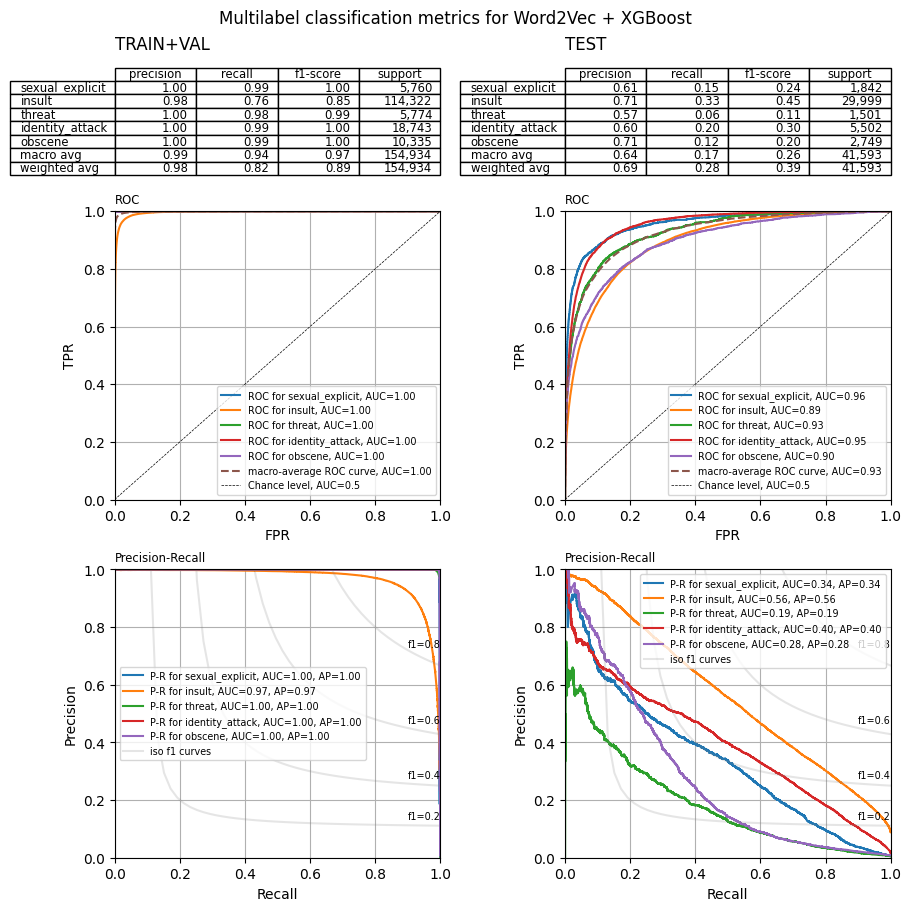

In [ ]:
plot_metrics_multi(
    xgb_multi,
    'Word2Vec + XGBoost',
    multilabel_cols,
    X_train_val_wv_tfidf,
    y_train_val[multilabel_cols],
    X_test_wv_tfidf,
    y_test[multilabel_cols],
    'TRAIN+VAL',
    'TEST')